In [2]:
import geopandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
df = pd.read_csv("visu_data.csv")
#import NY map file
boros = geopandas.read_file(geopandas.datasets.get_path("nybb"))

In [4]:
boros.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [5]:
df.head()

,id,summary,house_rules,host_response_rate,neighbourhood_group_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,...,Bronx,Staten_Island,Entire home,Private_room,Shared_room,flexible,moderate,strict_14,strict_30,strict
0,2595,"Find your romantic getaway to this beautiful, ...","Make yourself at home, respect the space and t...",90%,Manhattan,Entire home/apt,2,1.0,0.0,1.0,...,0,0,1,0,0,0,0,1,0,0
1,5099,My large 1 bedroom apartment is true New York ...,• Check-in time is 2PM. • Check-out time is 12...,90%,Manhattan,Entire home/apt,2,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
2,5222,N,Please let me know if you will be staying with...,100%,Manhattan,Entire home/apt,2,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
3,5238,"Live like a New Yorker instead of a stuffy, ti...",No smoking in apartment. No Pets allowed. Ple...,100%,Manhattan,Entire home/apt,3,1.0,1.0,2.0,...,0,0,1,0,0,0,0,1,0,0
4,5295,N,"Dear Guests, Welcome to my apartment and I hop...",100%,Manhattan,Entire home/apt,2,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0


## Average price of Boro

In [6]:
#preprocessing the data: price -> numerical 
df['price']= df['price'].astype(str).str.replace('$','')
df['price']= df['price'].str.replace(',','')
df['price'] = df['price'].astype(float)
df = df[df['price'] != 0]

In [7]:
# find the average price each neighbourhood group
fdf = df.groupby("neighbourhood_group_cleansed")['price'].mean().reset_index()
# sort_values() does not change the index of the rows, reset_index() is used to fix this, making sure Borough index is same
Boros = boros.sort_values(by=['BoroName'], ascending = False).reset_index()
fdf.price = round(fdf.price,2)
fdf

,neighbourhood_group_cleansed,price
0,Bronx,85.89
1,Brooklyn,128.57
2,Manhattan,194.95
3,Queens,99.62
4,Staten Island,90.89


In [8]:
Boros.head()

,index,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
3,2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
4,4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [9]:
Boros["price"] = fdf["price"]

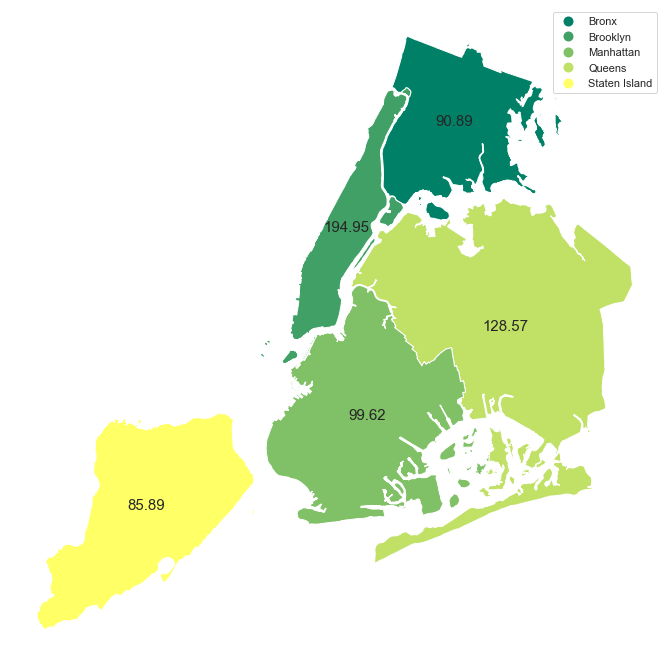

In [18]:
# create a geodataframe containing centroids of the boroughs
centroid_coords = geopandas.GeoDataFrame(
                          pd.DataFrame({'BoroName': Boros.BoroName}), 
                          geometry=geopandas.points_from_xy(
                              Boros["geometry"].centroid.x, 
                              Boros["geometry"].centroid.y
                          )
                  )
# set the coordinate system of centroid_coords to the same as of boros
centroid_coords.crs = Boros.crs
# add the price to display for each borough
centroid_coords["price"] = Boros['price']
# plot the boroughs
fig, ax = plt.subplots(1, 1, figsize=(12,12))
my_plot = boros.to_crs({"init": "epsg:4326"}).plot(column=centroid_coords.BoroName, 
                                                   cmap='summer', ax=ax,legend=True)
ax.set_axis_off()
# plot the text for each borough
for idx, row in centroid_coords.to_crs({"init": "epsg:4326"}).iterrows():
    plt.annotate(s= row['price'], 
                 xy=(row['geometry'].x, row['geometry'].y),
                 horizontalalignment='center', fontsize=15)
plt.savefig('Average price Per Borough.png')

## Total airbnb of each Boro

In [11]:
# find the total Airbnb listings each neighbourhood group
gdf = df.groupby("neighbourhood_group_cleansed")['id'].count().reset_index() 
gdf

,neighbourhood_group_cleansed,id
0,Bronx,2080
1,Brooklyn,33923
2,Manhattan,33876
3,Queens,10436
4,Staten Island,837


In [12]:
Boros["listings"] = gdf["id"]

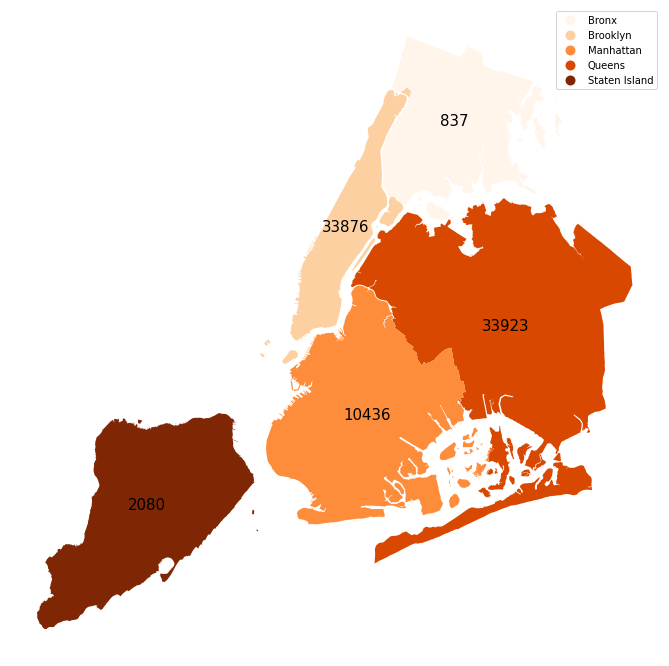

In [13]:
# add the listings to display for each borough 
centroid_coords["listings"] = Boros.listings
# plot the boroughs
fig, ax = plt.subplots(1, 1, figsize=(12,12))
my_plot = boros.to_crs({"init": "epsg:4326"}).plot(column=centroid_coords.BoroName, 
                                                   cmap='Oranges', ax=ax,legend=True)
ax.set_axis_off()
# plot the text for each borough
for idx, row in centroid_coords.to_crs({"init": "epsg:4326"}).iterrows():
    plt.annotate(s= row["listings"], 
                 xy=(row['geometry'].x, row['geometry'].y),
                 horizontalalignment='center', fontsize=15)
plt.savefig('Total listings Per Borough_read.png')

## Total room types in each Boro

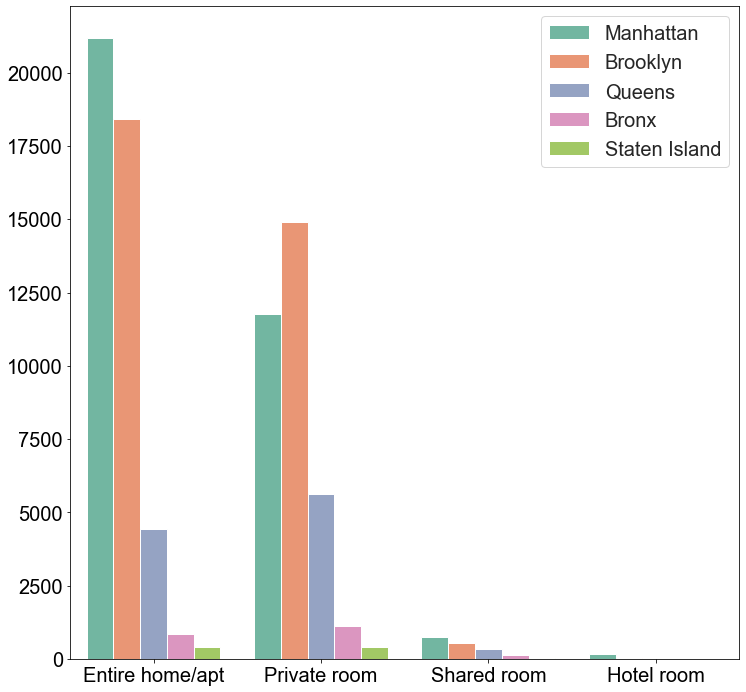

In [14]:
#create count plot for room types
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12,12))
sns.set(style="ticks")
sns.countplot(x='room_type', hue="neighbourhood_group_cleansed", data=df, ax=ax, palette="Set2")
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('Room Types Per Borough.png')

## House Rules Worldcould

In [16]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

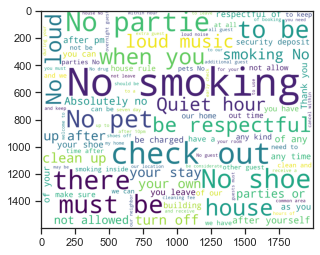

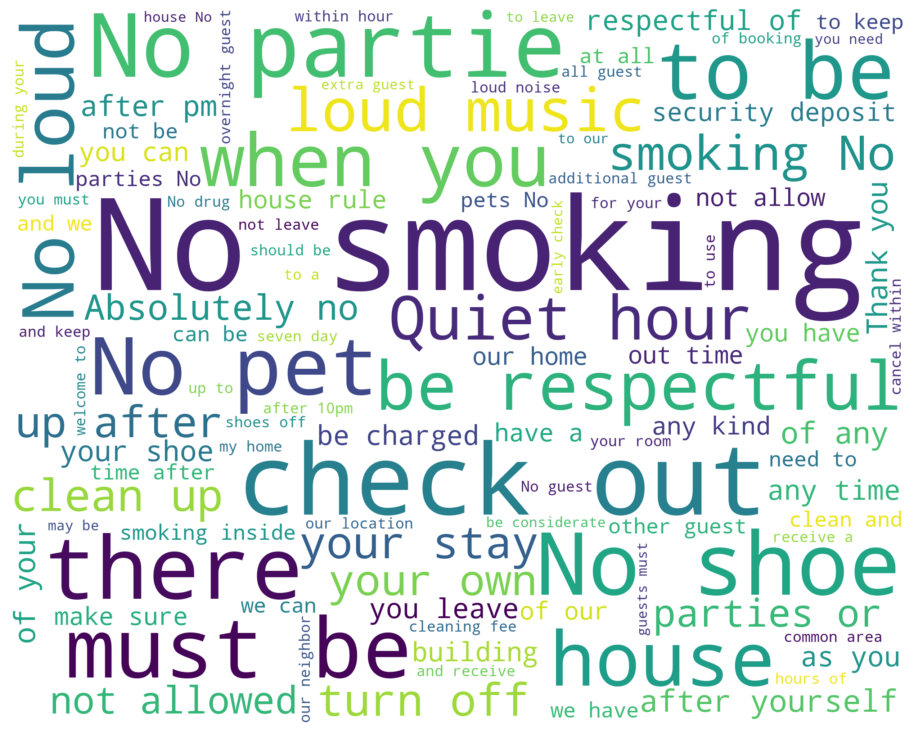

In [17]:
# house rules
df_hr = df['house_rules']
lines = []
for i in df_hr:
    lines.append(i)
text = ''.join(lines)

stopwords = ('Please keep','Please','please','this','is','the','that','If','will','are','in','apartment','do')

wc = WordCloud(background_color='white',max_words=100, width=2000, height=1600, stopwords=stopwords, margin=10,random_state=1).generate(text)
plt.imshow(wc)
wc.to_file('wordcloud_figure.png')
plt.figure(figsize=(20,10))
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
#plt.show()
plt.savefig('House Rules.png')